<a href="https://colab.research.google.com/github/WilliamLu1999/Data-Projects/blob/main/reddit_api_sentiment_analysis_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Reddit's API Charging Policy

### Table of Contents
* [Introduction](#section-1)
* [Ask: Questions, Hypothesis](#section-2)
* [Prepare: Fetch Data](#section-3)
* [Process: Clean Data](#section-4)
* [Analyze: Sentiment Analysis and Visualizations](#section-5)
* [Share: Insights](#section-6)
* [Act: Web Application](#section-7)



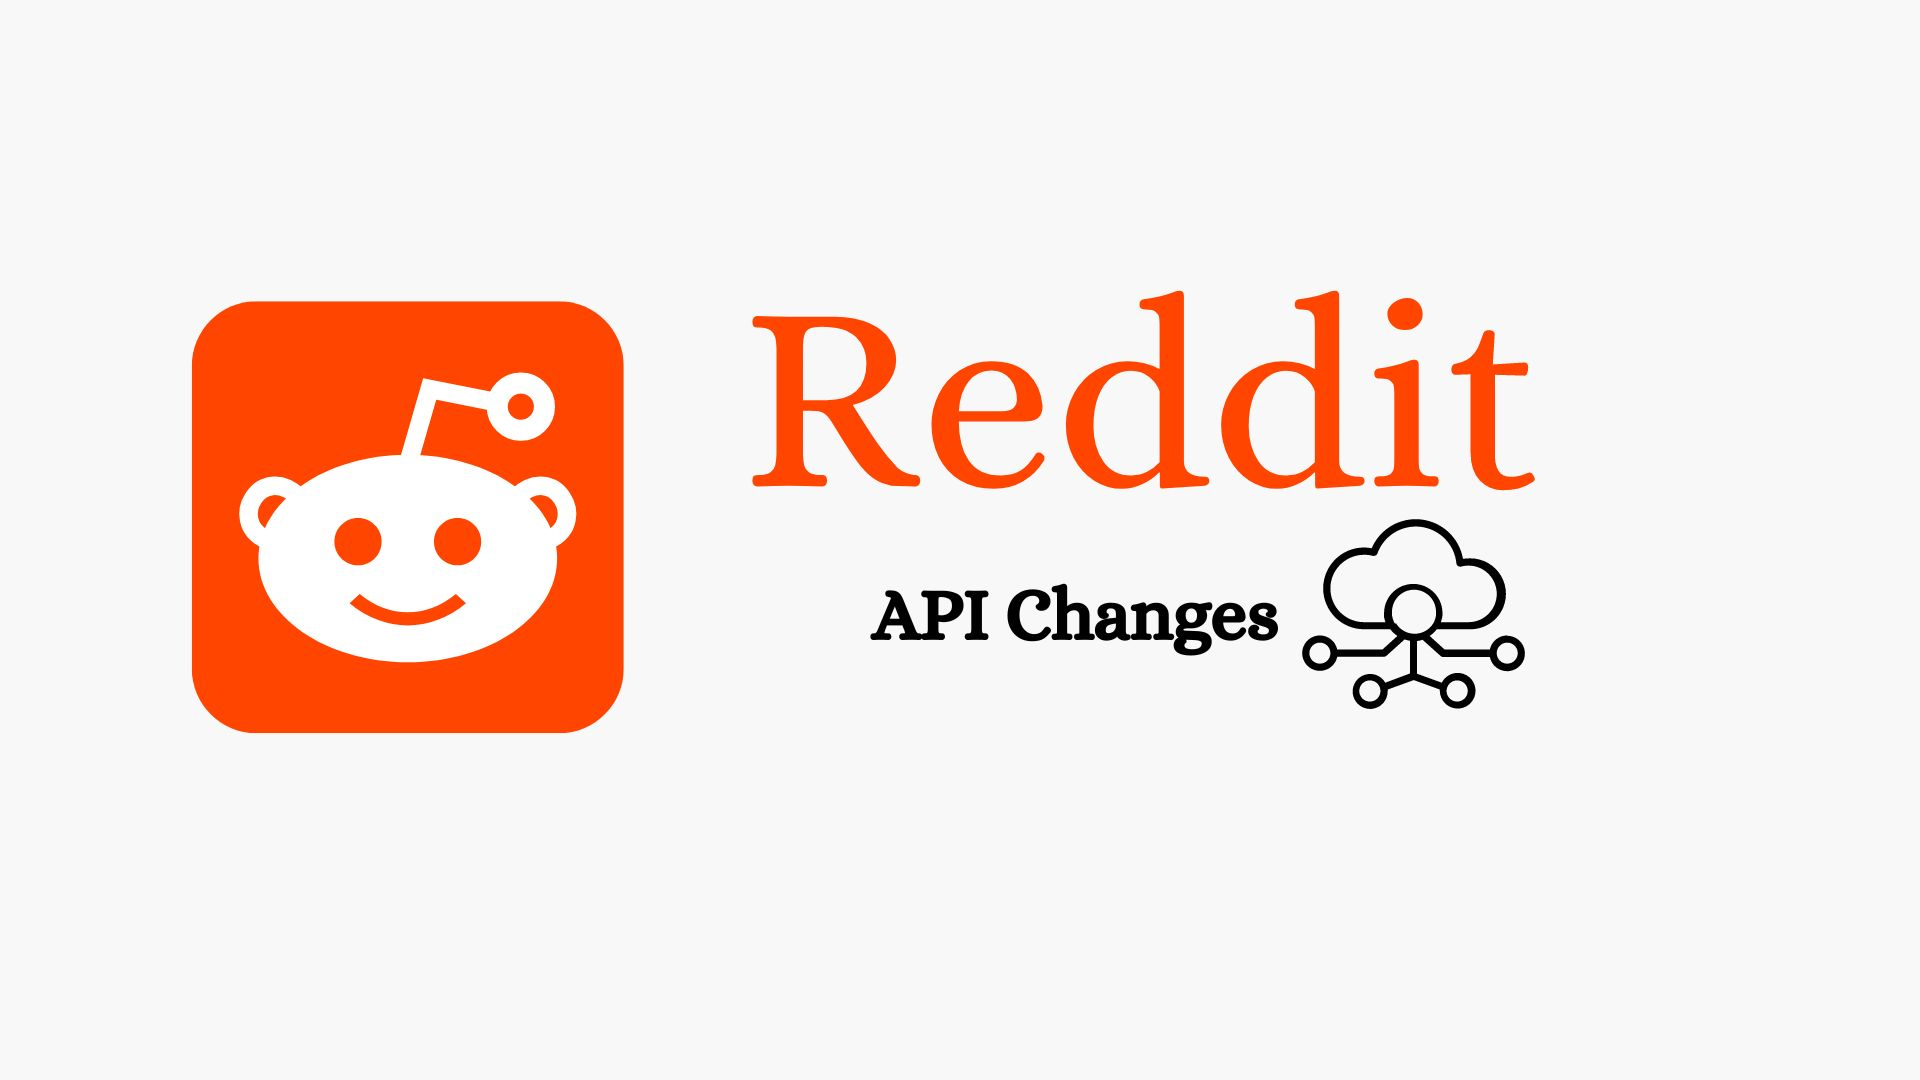


*Retrieved from: https://blogiestools.com/reddit-api-changes/*


<a id="section-1"></a>
### Introduction

*A. Backgroud*


Reddit is one of the biggest social media platforms that consists tons of niches (subreddits), covering a myriad of topics. Users (redditors) can create, share, comment, vote,etc. contents on Reddit.

*B. What happened?*

However, in April 2023, Reddit announced a new policy, which mainly stated that Reddit would start to charge third-party-applications for using its application-programming interface (API). API is a way for two or more computer programs to communicate with each other. It is a type of software interface, offering a service to other pieces of software. <wiki> Reddit's API was free to use since 2005 till 2023.

Now many applications that provide great service by adopting the free use of Reddit's API before are starting to shut down. For example, Apollo ReddPlanet and Sync (both are applications that provide a smooth and beautiful interface for browsing Reddit contents). Besides business shutting down, redditors also protest against this move -- nearly 9,000 subreddits went dark as an act of rebellion starting June 12, some of which with 30 million subscribers.


*C. Why this happened?*

According to Reddit CEO Steve Huffman, big tech companies such as Google, Microsoft, and OpenAI are using Reddit's contents to train LLM and for other AI usage freely. It's unsustainable if Reddit continues not charging any cost for its API.


*D. Souces:*

https://www.entrepreneur.com/business-news/reddit-blackout-protests-explained-api-changes-ceo-and/454629

https://www.zdnet.com/article/reddit-is-in-danger-of-a-death-spiral/


<a id="section-2"></a>
### Ask: Questions, Hypothesis
A. Questions

1.   What are the major sentiments of this topic?
2.   What do people response regards to this problem?
3.   Is it a good move or a bad move for Reddit?
4.   After 2-3 months, will people still be mad? (later after new data are fetched)

B. Hypothesis


1.   Angry and disappointment are the main sentiments of the comments.
2.   People will use them less frequently according to their comments; they will surf other websites as a substitution.
3.   It's in general a bad move at first, but the problem will be sorted out as time goes by since users rely on Reddit too much. Reddit's contents are great in many ways.
4.   Sarcasm in comments occur also quite frequently.




<a id="section-3"></a>
### Prepare: Fetch Data


To fetch the appropriate data, I use the YouTube API, which is free in contrast, to download comments from several videos about Reddit's API charging policy and change.

There are not too many videos about this, and since the issue is still hot so the contents of these may be a bit similar. However, I decide to add more data in the next few months to analyze people's emotions on this issue more.

In [11]:
#pip install contractions

In [12]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=f9e4797979fbf382b3e0e9674ba4f4c2e73484d40d4a02b96eecd86516444076
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [35]:
from google.colab import drive
drive.mount('/content/drive')

# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv

# import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import for sentiment analysis
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re
import contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# fetch YouTube Data
from googleapiclient.discovery import build

# spark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from itertools import combinations
import pyspark
import time
import random
import itertools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
from googleapiclient.discovery import build
# Youtube API Key is stored in this text file. Not directly using it for safety reason.
with open('/content/drive/MyDrive/data/youtube_API.txt', 'r') as file:
    file_content = file.read()

api_key = str(file_content)
'''
def get_video_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)

    comments = []
    nextPageToken = None

    while True:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        ).execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        nextPageToken = response.get('nextPageToken')

        if not nextPageToken:
            break

    return comments
  '''
'''
def get_video_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)

    comments = []
    nextPageToken = None

    while True:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        ).execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_id = item['snippet']['topLevelComment']['id']
            comments.append({
                'comment': comment,
                'upvotes': 0,
                'downvotes': 0
            })

            # Get comment statistics
            comment_response = youtube.comments().list(
                part='snippet',
                id=comment_id
            ).execute()

            if 'items' in comment_response and len(comment_response['items']) > 0:
                comment_stats = comment_response['items'][0]['snippet']['likeCount']
                comments[-1]['upvotes'] = int(comment_stats)

            comment_response = youtube.comments().list(
                part='snippet',
                parentId=comment_id
            ).execute()

            if 'items' in comment_response and len(comment_response['items']) > 0:
                comment_stats = comment_response['items'][0]['snippet']['likeCount']
                comments[-1]['downvotes'] = int(comment_stats)

        nextPageToken = response.get('nextPageToken')

        if not nextPageToken:
            break

    return comments
'''
def get_video_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)

    comments = []
    nextPageToken = None

    while True:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        ).execute()

        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_id = item['snippet']['topLevelComment']['id']
            comments.append({
                'comment': comment,
                'upvotes': 0,
                'downvotes': 0
            })

            # Get comment statistics
            comment_response = youtube.commentVotes().list(
                id=comment_id
            ).execute()

            if 'items' in comment_response and len(comment_response['items']) > 0:
                for vote in comment_response['items']:
                    vote_type = vote['snippet']['type']
                    vote_count = vote['snippet']['totalVoteCount']
                    if vote_type == 'like':
                        comments[-1]['upvotes'] = int(vote_count)
                    elif vote_type == 'dislike':
                        comments[-1]['downvotes'] = int(vote_count)

        nextPageToken = response.get('nextPageToken')

        if not nextPageToken:
            break

    return comments

# Enter video ID
video_id1 = "Ch6zNEq9fwM"

# Call the function to retrieve comments
comments1 = get_video_comments(video_id1)

In [37]:
comments1

[{'comment': 'I support anything that pisses off redditors and mods',
  'upvotes': 0,
  'downvotes': 0},
 {'comment': 'Fuck Reddit, one of the shittiest platforms ever',
  'upvotes': 2,
  'downvotes': 0},
 {'comment': 'Couldn&#39;t imagine being part of that trash',
  'upvotes': 0,
  'downvotes': 0},
 {'comment': 'What&#39;s wrong with the regular reddit app? Genuinely asking',
  'upvotes': 2,
  'downvotes': 1},
 {'comment': 'As a non-redditor who ends up on reddit because apparently reddit is a viable alternative to wikis, forums, and everything else all of a sudden (it isn&#39;t and never will be), the only thing I care about is making the side bar being hideable and the actual content filling the page without having to use javascript and CSS hacks. I&#39;m glad they&#39;re employing fees on the grifters and groomers. Maybe they will get rid of them and the people who actually use reddit/have to use reddit&#39;s voice will be heard over the jannies. A win for all (probably.)',
  'upv

In [38]:
# comment out below for future runs
video_id2 = "fBruoybHryU"
comments2 = get_video_comments(video_id2)
video_id3 = "VO-iMK-1ljY"
comments3 = get_video_comments(video_id3)
video_id4 = "vGG_zmcSHJo"
comments4 = get_video_comments(video_id4)
video_id5 = "U06rCBIKM5M"
comments5 = get_video_comments(video_id5)
video_id6 = "nXYOdnn_FLo"
comments6 = get_video_comments(video_id6)
video_id7 = "LxlVe1xwPQc"
comments7 = get_video_comments(video_id7)
video_id8 = 'zL0yFvkLMQc'
comments8 = get_video_comments(video_id8)
video_id9 = 'bXRVRu-qWFU'
comments9 = get_video_comments(video_id9)
video_id10 = 'TEVzqTi_cls'
comments10 = get_video_comments(video_id10)
video_id11 = 'WusFlgO8FX0'
comments11 = get_video_comments(video_id11)

comments = comments1+comments2+comments3+comments4+comments5+comments6+comments7+comments8+comments9+comments10+comments11
# Specify the output CSV file path on Google Drive
csv_file_path = '/content/drive/MyDrive/data/reddit_api_comments.csv'

# transform the list of comments to a dataframe
df = pd.DataFrame(comments, columns=['comments'])
# store the dataframe as a csv
df.to_csv(csv_file_path,index=False)

HttpError: ignored

In [4]:
# run this for every new run
rc = pd.read_csv('/content/drive/MyDrive/data/reddit_api_comments.csv')
rc

,comments
0,What&#39;s wrong with the regular reddit app? ...
1,As a non-redditor who ends up on reddit becaus...
2,First
3,Mods need to get over themselves.
4,I never thought thatr deleting my account woul...
...,...
11894,Gah daymn
11895,Ok
11896,Kinda knew it<br><br><br><br>Edit i am the 3rd
11897,Looks like not enough Redditors assembled


<a id="section-4"></a>
### Process: Clean Data

At the first glance, you see some comments have special charatcers (like the first comment), some have capital letters, and some comments may not deliver any sentiment values (like 'First'). Hence, let's make the comments clean first!




*   Convert all comments to lower letters
*   Remove HTML and urls from comments
*   Remove non-alphabetical characters
*   Perform contractions
*   Remove extra space
*   Remove stop words
*   Perform lemmatization

In [5]:
# find the average comment length before cleaning
rc['comments before'] = rc['comments']
pre_length = rc['comments'].apply(len).mean()
rc['comments'] = rc['comments'].astype(str)
# convert all reviews to lowercase
rc['comments']= rc['comments'].str.lower()
# remove urls from the reviews
rc["comments"] = rc["comments"].str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip()
# remove htmls tag from the reviews
rc['comments'] = rc['comments'].str.replace(r'<[^<>]*>', '', regex=True)
# remove numerics
rc['comments'] = rc['comments'].str.replace('\d+', '',regex=True)
# remove non-alphabetical characters
rc['comments'] = rc['comments'].str.replace('[^a-zA-Z0-9]', ' ', regex=True)
# perform contractions
rc['comments'] = rc['comments'].apply(lambda x: contractions.fix(x))
# remove extra space
rc['comments'] = rc['comments'].str.strip()
stop = nltk.corpus.stopwords.words('english')
rc['comments withno stopwords'] = rc['comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
lmtzr = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN,"V":wordnet.VERB,"J":wordnet.ADJ,"R":wordnet.ADV}
# define a lemmatization function and then we can pass in a panda series to perform lemmatization
def lemmatization(series):
    pos_tagged = nltk.pos_tag(series.split())
    return ' '.join([lmtzr.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged])
rc['comments final'] = rc['comments withno stopwords'].apply(lambda x: lemmatization(x))

<ipython-input-5-dbe8f7c629d2>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  rc["comments"] = rc["comments"].str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip()


In [6]:
post_length = rc['comments'].apply(len).mean()
print("Calculating the average comment length......")
print(f"Before cleaning: {pre_length}, after cleaning: {post_length}, length difference: {pre_length-post_length}")
rc.drop(columns = ["comments"])

Calculating the average comment length......
Before cleaning: 154.63030506765276, after cleaning: 149.16623245650894, length difference: 5.46407261114382


,comments before,comments withno stopwords,comments final
0,What&#39;s wrong with the regular reddit app? ...,wrong regular reddit app genuinely asking,wrong regular reddit app genuinely ask
1,As a non-redditor who ends up on reddit becaus...,non redditor ends reddit apparently reddit via...,non redditor end reddit apparently reddit viab...
2,First,first,first
3,Mods need to get over themselves.,mods need get,mod need get
4,I never thought thatr deleting my account woul...,never thought thatr deleting account would sat...,never think thatr delete account would satisfy
...,...,...,...
11894,Gah daymn,gah daymn,gah daymn
11895,Ok,ok,ok
11896,Kinda knew it<br><br><br><br>Edit i am the 3rd,kind knew itedit rd,kind know itedit rd
11897,Looks like not enough Redditors assembled,looks like enough redditors assembled,look like enough redditors assemble


<a id="section-5"></a>
### Analyze: Sentiment Analysis & Visualizations

NLTK's VADER: Assign sentiment score to each comment and classify comments into three categories - positive, negative, and neutral.

In [7]:
# this approach does not consider relationships between words
sentiments = SentimentIntensityAnalyzer()
rc["positive"] = [sentiments.polarity_scores(i)["pos"] for i in rc["comments final"]]
rc["negative"] = [sentiments.polarity_scores(i)["neg"] for i in rc["comments final"]]
rc["neutral"] = [sentiments.polarity_scores(i)["neu"] for i in rc["comments final"]]
rc['compound'] = [sentiments.polarity_scores(i)["compound"] for i in rc["comments final"]]
score = rc["compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('positive')
    elif i <= -0.05 :
        sentiment.append('negative')
    else:
        sentiment.append('neutral')
rc["sentiment"] = sentiment
rc.head()

,comments,comments before,comments withno stopwords,comments final,positive,negative,neutral,compound,sentiment
0,what s wrong with the regular reddit app ge...,What&#39;s wrong with the regular reddit app? ...,wrong regular reddit app genuinely asking,wrong regular reddit app genuinely ask,0.000,0.383,0.617,-0.4767,negative
1,as a non redditor who ends up on reddit becaus...,As a non-redditor who ends up on reddit becaus...,non redditor ends reddit apparently reddit via...,non redditor end reddit apparently reddit viab...,0.125,0.048,0.827,0.6336,positive
2,first,First,first,first,0.000,0.000,1.000,0.0000,neutral
3,mods need to get over themselves,Mods need to get over themselves.,mods need get,mod need get,0.000,0.000,1.000,0.0000,neutral
4,i never thought thatr deleting my account woul...,I never thought thatr deleting my account woul...,never thought thatr deleting account would sat...,never think thatr delete account would satisfy,0.333,0.000,0.667,0.4588,positive


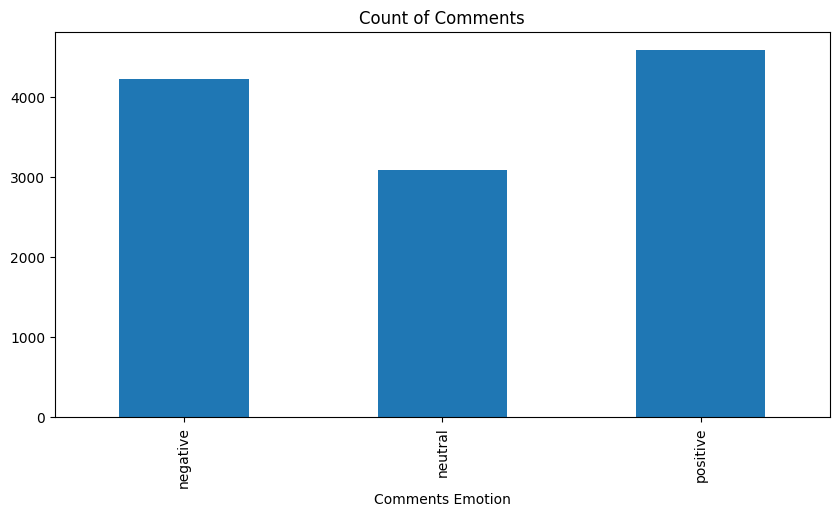

In [17]:
ax = rc['sentiment'].value_counts().sort_index()\
.plot(kind ='bar',title ='Count of Comments',figsize=(10,5))
ax.set_xlabel('Comments Emotion')
plt.show()

In [31]:
print(rc['comments before'][4],sentiments.polarity_scores(rc['comments before'][4]))
# this is a more of a sarcastic comment than a positive comment.
print("I am soo happy!",sentiments.polarity_scores("I am soo happy!"))

I never thought thatr deleting my account would be so satisfying {'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound': 0.5949}
I am soo happy! {'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6114}


In [ ]:
ax = sns.barplot(data=rc,x='')
ax.set_title('Compound Score of Reddit\s comments ')

In [22]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokens = nltk.word_tokenize(rc['comments final'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


TypeError: ignored

In [ ]:
nltk.pos_tag(tokens)

In [ ]:
# create a spark app
sc = pyspark.SparkContext(appName="reddit")
rc_spark = sc.read.csv()

<a id="section-6"></a>
### Share: Insights


<a id="section-7"></a>
### Act: Web Applications